<a href="https://colab.research.google.com/github/mohamedtal/PFE2021/blob/main/30_03_2021_Densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import cv2
import warnings
import shutil
import os
#import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout
from matplotlib import pyplot


# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Keras.
import cv2
import numpy as np
import os
import random
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet121
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

# to generate data augmentation a partir de aptos 2019 preprocessed
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import cv2
%matplotlib inline

In [2]:
# before all don't forget to use the GPU

# at first we need to get the dataset from the drive 
# pfe2021.1@gmail.com		zakimoha123
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
#unzip the dataset

# for the train
!unzip /content/drive/MyDrive/dataset/DR-dataset2015.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: DR-dataset/train/2/3213_right.jpg  
  inflating: DR-dataset/train/2/15711_left.jpg  
  inflating: DR-dataset/train/2/43042_left.jpg  
  inflating: DR-dataset/train/2/13786_right.jpg  
  inflating: DR-dataset/train/2/40319_left.jpg  
  inflating: DR-dataset/train/2/13667_left.jpg  
  inflating: DR-dataset/train/2/3778_right.jpg  
  inflating: DR-dataset/train/2/44263_right.jpg  
  inflating: DR-dataset/train/2/10438_right.jpg  
  inflating: DR-dataset/train/2/25458_right.jpg  
  inflating: DR-dataset/train/2/40201_left.jpg  
  inflating: DR-dataset/train/2/32668_left.jpg  
  inflating: DR-dataset/train/2/19202_left.jpg  
  inflating: DR-dataset/train/2/22461_left.jpg  
  inflating: DR-dataset/train/2/40676_left.jpg  
  inflating: DR-dataset/train/2/41335_right.jpg  
  inflating: DR-dataset/train/2/10468_left.jpg  
  inflating: DR-dataset/train/2/2705_left.jpg  
  inflating: DR-dataset/train/2/3399

preprocessing function (crop+resizing+clahe)

In [4]:
def preprocessFunction(image):
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thresh = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()
    if x2-x1>100 and y2-y1>100 :
        kopya2 = kopya2[y1+y:y2-y , x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    lab = cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son,3)
    arka_plan = cv2.medianBlur(son,37)
    maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
    son_img = cv2.bitwise_and(maske,med_son)
    return son_img


In [5]:
# creating the batches folder
path_train = 'train'
path_test = 'test'

def createBatchFolder(pathName):
    try:
        os.mkdir(pathName)
    except OSError:
        print ("Creation of the directory %s failed" % pathName)
    else:
        print ("Successfully created the directory %s " % pathName)
    finally:
        for i in range(5):
          try:
              pathBatch = pathName+'/'+str(i)
              os.mkdir(pathBatch)
          except OSError:
              print ("Creation of the directory %s failed" % pathName)

# call the create path function
createBatchFolder(path_train)
createBatchFolder(path_test)

Successfully created the directory train 
Successfully created the directory test 


In [6]:
#read images, do division, save results batches
path = 'DR-dataset/train/'
numberTrainImagesPerClass = 600
numberTestImagesPerClass = 100
numberOfClass = 5

def getData(path,path_batch,path_test,numberTrainImagesPerClass,numberTestImagesPerClass,numberOfClass):
    for c in range(numberOfClass):
      # the path of each class
      path_class = path + str(c)
      # get the list of images in each class
      list_images =  os.listdir(path_class)
      # choose randomly 300 images from the previous list
      choosed_images = random.sample(list_images, numberTrainImagesPerClass+numberTestImagesPerClass)
      # get train dataset
      for k in range(numberTrainImagesPerClass):
        # get the path of each image
        image = choosed_images[k]
        path_image = path_class+'/'+ image
        # read the image
        img = cv2.imread(path_image)
        try:
          img = preprocessFunction(img)
        except:
          pass
        try:
            newPath = path_batch+'/'+str(c)+'/'+image
            cv2.imwrite(newPath,img)
        except Exception as e:
            print(img.shape)
            print('error_train'+str(e))
      # get the test dataset
      for k in range(numberTrainImagesPerClass,numberTrainImagesPerClass+numberTestImagesPerClass):
        # get the path of each image
        image = choosed_images[k]
        path_image = path_class+'/'+ image
        # read the image
        img = cv2.imread(path_image)
        try:
          img = preprocessFunction(img)
        except:
          pass
        try:
            newPath = path_test+'/'+str(c)+'/'+image
            cv2.imwrite(newPath,img)
        except Exception as e:
            print(img.shape)
            print('error_train'+str(e))

getData(path,path_train,path_test,numberTrainImagesPerClass,numberTestImagesPerClass,numberOfClass)

In [9]:
#!rm -r DR-dataset2019-Preprocessed/3
!ls train/0 | wc -l
!ls test/0 | wc -l

3000
100


In [8]:
# augmenttaion
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

for i in range(5):
  BASE_DIR = "train/"+str(i)
  NEW_DIR= "train/"+str(i)
  list_dir =  os.listdir(BASE_DIR)
  for images in list_dir:
      image = cv2.imread(BASE_DIR + "/"+ images)
      #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
          # rotation
      
      rotate=iaa.Affine(rotate=(1, 30))
      rotated_image=rotate.augment_image(image)
      cv2.imwrite(NEW_DIR + "/" + 'rotated-'+images,rotated_image)

      #zoom
      crop = iaa.Crop(percent=(0.07, 0.12)) # crop image
      corp_image=crop.augment_image(image)
      cv2.imwrite(NEW_DIR + "/" + 'zoomed-'+images,corp_image)


      crop = iaa.Affine(shear=10)
      corp_image=crop.augment_image(image)
      cv2.imwrite(NEW_DIR + "/" + 'affine-'+images,corp_image)

      #flip H
      flip_hr=iaa.Fliplr(p=1.0)
      flip_hr_image= flip_hr.augment_image(image)
      cv2.imwrite(NEW_DIR + "/" + 'fliph-'+images,flip_hr_image)


In [10]:
def createModel():
  pre_trained_model = DenseNet121(input_shape = (224,224,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

  model = Sequential()
  model.add(pre_trained_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=0.00005),
      metrics=['accuracy']
  )
  return model

In [20]:
# read test data
test_datagen = ImageDataGenerator(
      rescale=1./255,
      ) 

test_generator = train_datagen.flow_from_directory(
      path_test,
      classes = ['0','1','2','3','4'],
      target_size=(224, 224),
      color_mode='rgb',
      batch_size=batchSize,
      class_mode='categorical')

Found 500 images belonging to 5 classes.


In [12]:
models_path = 'models'
from keras.preprocessing.image import ImageDataGenerator
import numpy
import math
batchSize = 32

train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.15
      ) 

train_generator = train_datagen.flow_from_directory(
      path_train,
      classes = ['0','1','2','3','4'],
      target_size=(224, 224),
      color_mode='rgb',
      batch_size=batchSize,
      class_mode='categorical',
      subset='training',
      shuffle=True)

  # ******* for validation dataset
val_generator = train_datagen.flow_from_directory(
      path_train,
      classes = ['0','1','2','3','4'],
      class_mode='categorical',
      target_size=(224, 224),
      color_mode='rgb',
      subset='validation'
  )
model = createModel()
  # 
earlystopper = EarlyStopping(
            monitor = "val_loss",
            mode="min",
            patience=10,
            verbose=1
  )
model_checkpoint = ModelCheckpoint(
              models_path+'/modelBatch'+str(i),
              monitor='val_loss',
              verbose=1,
              save_best_only=True
  )
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples//batchSize),
    epochs=50,
    validation_data = val_generator,
    validation_steps = math.ceil(val_generator.samples//batchSize),callbacks=[model_checkpoint,earlystopper],
    verbose = 1)

Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
29089792/29084464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
398/398 [==============================] - 152s 313ms/step - loss: 1.9833 - accuracy: 0.2575 - val_loss: 1.2724 - val_accuracy: 0.4482

Epoch 00001: loss improved from inf to 1.84663, saving model to models/modelBatch4
INFO:tensorflow:Assets written to: models/modelBatch4/assets
Epoch 2/50
398/398 [==============================] - 120s 302ms/step - loss: 1.5493 - accuracy: 0.3921 - val_loss: 1.1007 - val_accuracy: 0.5362

Epoch 00002: loss improved from 1.84663 to 1.51285, saving model to models/modelBatch4
INFO:tensorflow:Assets written to: models/modelBatch4/assets
Epoch 3/50
398/398 [==============================] - 121s 304ms/step - loss: 1.3555 - accuracy: 0.4553 - val_loss: 0.9875 - val_accuracy: 0.5906

Epoch 00003: loss improved from 1.51285 to 1.32805, saving model to models/modelBatch4
INFO:tensorflow:Assets written to: models/modelBatch4/assets
Epoch 4/50
398/398 [==============================] - 122s 306ms/step - loss: 1.1873 - accuracy: 0.5175 - val_loss: 0.9

In [13]:
# saving the model
model.save("idea0-Densenet121.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


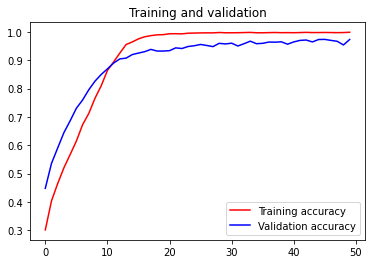

<Figure size 432x288 with 0 Axes>

In [14]:
# display the performance of the model graphically
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.plot(epochs, loss, 'g', label='Training loss')
#plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.show()

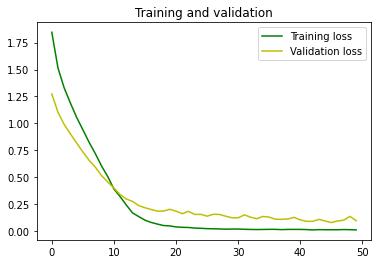

<Figure size 432x288 with 0 Axes>

In [15]:
# display the performance of the model graphically
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.show()

In [26]:
from tensorflow import keras
model = keras.models.load_model('idea0-Densenet121.h5')

In [27]:
score = model.evaluate(test_generator)
print(score)

16/16 [==============================] - 5s 220ms/step - loss: 2.9496 - accuracy: 0.4640
[2.949622869491577, 0.46399998664855957]


In [24]:
import numpy as np
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(probabilities, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [25]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
mat = confusion_matrix(y_true, y_pred)
print(mat)
class_labels = list(val_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

[[19 26 14 21 20]
 [17 25 13 18 27]
 [20 31 19 12 18]
 [23 30 12 17 18]
 [22 32 15 10 21]]
              precision    recall  f1-score   support

           0       0.19      0.19      0.19       100
           1       0.17      0.25      0.20       100
           2       0.26      0.19      0.22       100
           3       0.22      0.17      0.19       100
           4       0.20      0.21      0.21       100

    accuracy                           0.20       500
   macro avg       0.21      0.20      0.20       500
weighted avg       0.21      0.20      0.20       500

